In [27]:
import os, glob, string, re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import seaborn as sns
plt.style.use('ggplot')

%matplotlib inline

In [28]:
# For plotting nicely

from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter

def millions(x, pos):
    'The two args are the value and tick position'
    return  (x*100)
csfont = {'fontname':'Arial'}
hfont = {'fontname':'Arial'}
formatter = FuncFormatter(millions)
sns.set_style("whitegrid",{'grid.color': '0.95','grid.linewidth': 0.01})
sns.set_context("poster")
mpl.rcParams['grid.linewidth'] = 0.7
mpl.rcParams['figure.autolayout'] =  True
#ax.yaxis.set_major_formatter(formatter)
#plt.rc('axes',edgecolor='white')
#plt.tick_params(axis='both', which='major', labelsize=28)




Downloading the data from the previous cleaning part

In [3]:
wordCountYear = pd.read_csv('3kplusWordMonth.csv',index_col=0)
wordCountYear.head()

,-a,-la,-le,-on,-—,aarau,aarberg,aarbourg,aarcorp,aarg,...,œcuménique,œcuménisme,œdipe,œil,œillet,œquo,œrlikon,œuf,œur-,œuvre
1806-05-01,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1806-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
1806-07-01,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1806-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
1806-09-01,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


Grouping to have the right index

In [4]:
wordCountYear = wordCountYear.groupby(wordCountYear.index, level=0).agg(sum)

Transforming the absolute occurence of every words into frequencies

In [5]:
wordCountYear.index = pd.to_datetime(wordCountYear.index)
yearIndex = wordCountYear.index
#normalization
wordNorm = wordCountYear.divide(wordCountYear.sum(axis=1).values,axis=0)

Here we show the visualization of the word 'vraie' that we are going to predict later. The word contain multiple words like vrai and vraie that have been agregated due to the pre processing.

//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


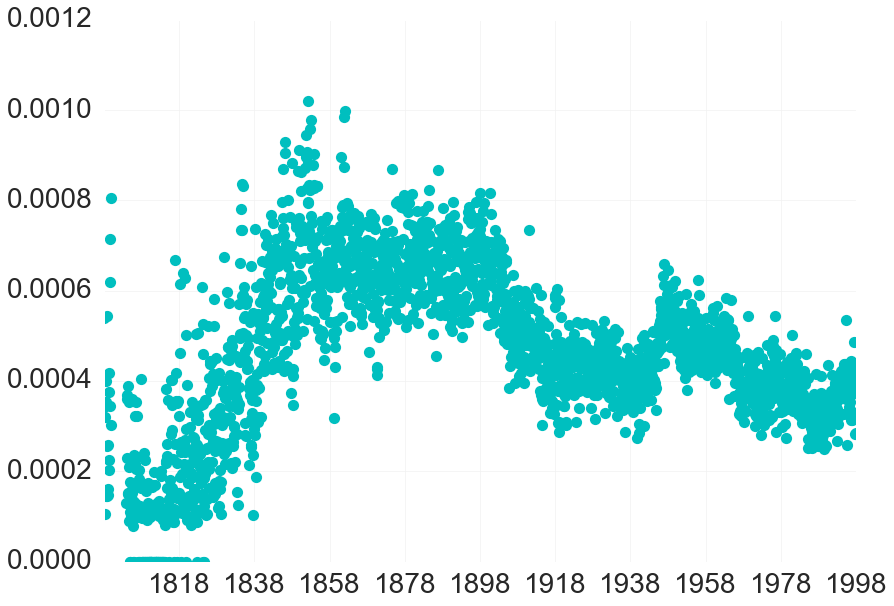

In [30]:
plt.plot_date(yearIndex,wordNorm['vraie'].values, c='c')

plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)

We select this time serie for the word 'vraie' and we reshape it in array form that suit the following of our processing

In [31]:
time_serie = wordNorm['vraie']

For better visualization at first, we only keep the first 900 months of the time series

In [32]:
time_serie_crop = time_serie[100:1100].copy()

In [33]:
#we store the index date of this time serie

crop_index = time_serie_crop.index

In [34]:
dataset = numpy.array(time_serie_crop).reshape((len(time_serie_crop),1))

In [35]:
dataset.shape

(1000, 1)

In order to facilitate the prediction we will smooth the time serie. To do so, we apply a exponential weighted moving average (ewma) on the data. As our data are frequency of words they are not continuous data. A specific word can be absent from a month, for example because a another subjet was more represented. Here we make the assumption that an ewma is a good transformation for smoothening the data without creating absurd results.

In [36]:
expwighted_avg = pd.ewma(dataset, halflife=10)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':


Here we can see the visualition of the time serie before the ewma processing

//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


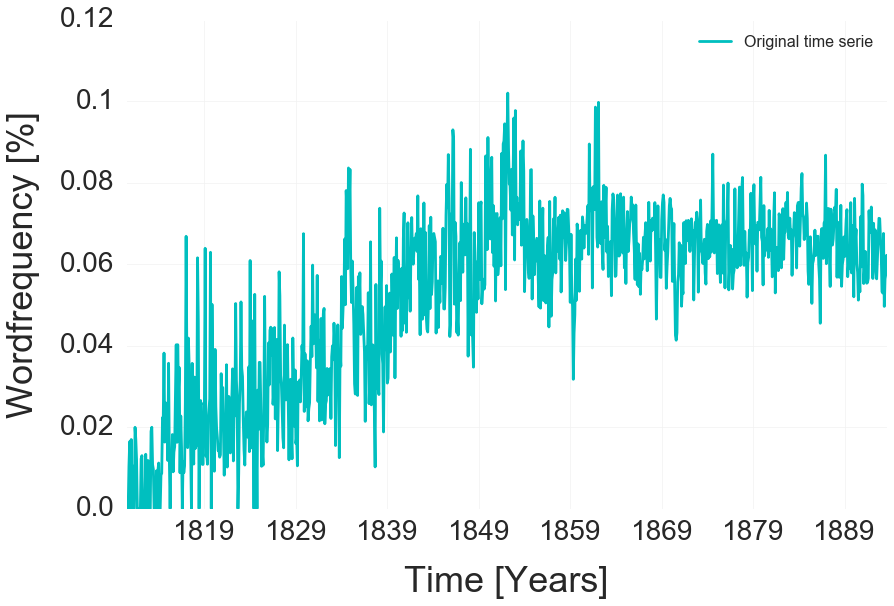

In [37]:
dataset_df = pd.DataFrame(dataset)
dataset_df.index = crop_index
ax = dataset_df.plot(c = 'c')

ax.set_xlabel('Time [Years]',fontsize=36,labelpad=20,**hfont)
ax.set_ylabel('Wordfrequency [%]',fontsize=36,labelpad=20,**hfont)

ax.yaxis.set_major_formatter(formatter)

ax.legend(["Original time serie"])

plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)

And here after the ewma processing

//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


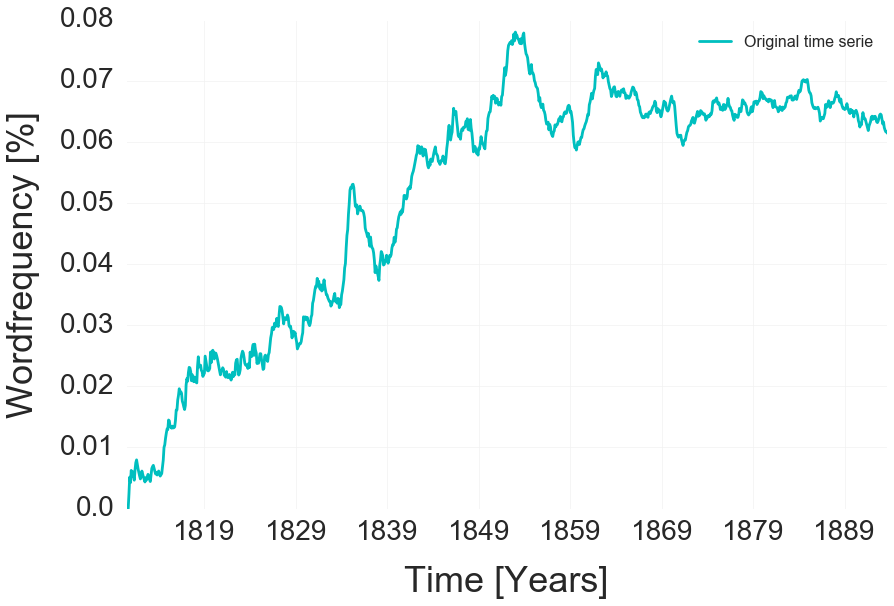

In [38]:

expwighted_avg_df = pd.DataFrame(expwighted_avg)
expwighted_avg_df.index = crop_index
ax = expwighted_avg_df.plot(c = 'c')

ax.set_xlabel('Time [Years]',fontsize=36,labelpad=20,**hfont)
ax.set_ylabel('Wordfrequency [%]',fontsize=36,labelpad=20,**hfont)

ax.yaxis.set_major_formatter(formatter)

ax.legend(["Original time serie"])

plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)

# Prediction of the time serie 

Now we will try to predict the frequency of the time serie. We will start with a relatively simple task which is to predict the serie one month ahead of the current value.

Our first approach will be to use long short term memory (LSTM). LSTM are a specific case of recurent neural network (RNN) which are neural network with self connection. That allow them to retain information from time step to time step and make them particularly suitable for sequential inputs. Thus, we can assume that they can be usefull for time series prediction and that we can apply them to our project.

First we need to phrase our time series into a regression probleme dataset. The order of the data is of course important in a time serie. What we do is that we take the data at time t and put it in a array X while correspondinlgy taking the data at time t + 1 (or more it depends at what horizon we want to predict) and putting it into a array Y. Hence we have a two array X and Y. X contain the data from the time serie and Y contain the same data but shifted from a arbitrary value chosen by us. The algorithme will try to predict the future frequency based on past frequency.

Here is the function processin the data as said previously. Note that we can chose to use more than one past frequency as feature for prediction the future frequency. This is done by chosing a bigger look_back parameter.

In [39]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-11):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back + 10 , 0])
    return numpy.array(dataX), numpy.array(dataY)

In [40]:
test_x, test_y = create_dataset(dataset)

Here, we process the data in as explained before. We also separate them in training and testing set so that we can evaluate our results later. We need to reshape the data so that they fit the LSTM keras model. Then the model is defined, compiled and fitted with data. Here we used the two previous monthly frequencies to predict the future frequency 10 month later.

In [41]:
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
data = expwighted_avg.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
# split into train and test sets
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=10, batch_size=1, verbose=2)

Epoch 1/10
8s - loss: 0.0607
Epoch 2/10
7s - loss: 0.0042
Epoch 3/10
8s - loss: 0.0025
Epoch 4/10
8s - loss: 0.0024
Epoch 5/10
9s - loss: 0.0025
Epoch 6/10
8s - loss: 0.0025
Epoch 7/10
8s - loss: 0.0025
Epoch 8/10
9s - loss: 0.0025
Epoch 9/10
8s - loss: 0.0025
Epoch 10/10
8s - loss: 0.0024


Now that our model was fittet with our data (trained) we can try to predict future frequency on the testing set (not used for training). Remember that we only predict the future frequency of one month separated from 10 month from the month used as features.

Train Score: 0.00 RMSE
Test Score: 0.00 RMSE
670


//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


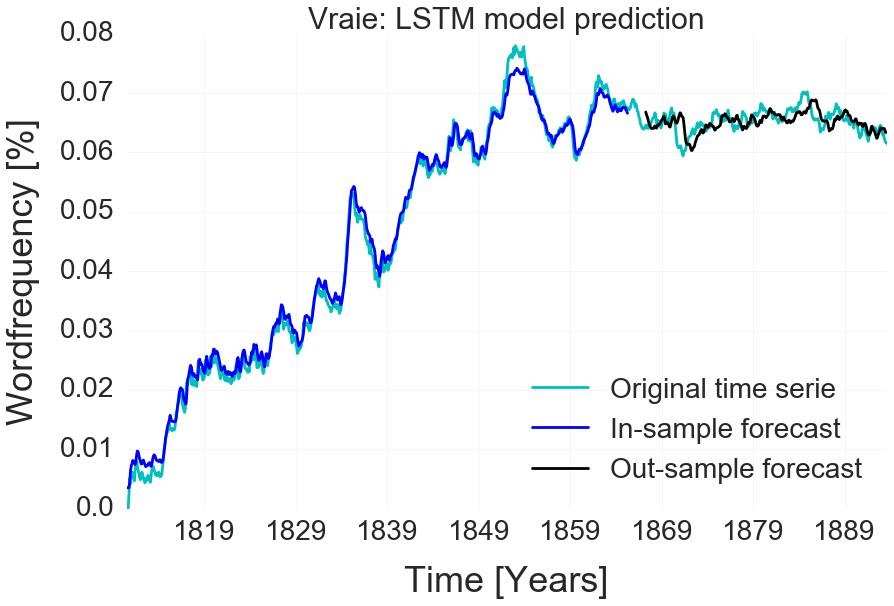

In [53]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY_processed = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_processed = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_processed[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_processed[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(data)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(data)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+((look_back+10)*2)+1:len(data)-1, :] = testPredict

#plotting final

data_inverse = scaler.inverse_transform(data)
data_inverse_df = pd.DataFrame(data_inverse)
data_inverse_df.index = crop_index

train_length = int(len(data) * 0.67)

print(train_length)

trainPredictPlot_df = pd.DataFrame(trainPredictPlot)
trainPredictPlot_df.index = crop_index

testPredictPlot_df = pd.DataFrame(testPredictPlot)
testPredictPlot_df.index = crop_index

ax = data_inverse_df.plot(c='c')

ax = trainPredictPlot_df.plot(ax=ax, style='b', label='Dynamic Prediction')

ax = testPredictPlot_df.plot(ax=ax, style='black', label='Dynamic Prediction')

ax.set_title("Vraie: LSTM model prediction", horizontalalignment='center', size=30)

ax.set_xlabel('Time [Years]',fontsize=36,labelpad=20,**hfont)
ax.set_ylabel('Wordfrequency [%]',fontsize=36,labelpad=20,**hfont)

ax.yaxis.set_major_formatter(formatter)

ax.legend(["Original time serie","In-sample forecast", "Out-sample forecast"], fontsize=28, loc='lower right')


plt.rc('axes',edgecolor='white')
plt.tick_params(axis='both', which='major', labelsize=28)

plt.savefig('Plots/LSTM_figure.png')

The green line is the training prediction and the red one is the testing prediction. We can see that the testing prediction is less precise than the training error as expected. 

Generally, we can see that the model performe really well. Taking into account the simplicity and the computation time used, these results would be really impressive. Does predicting time series really is that easy ?

That seem to good to be true and indeed it is.

After carefull examination, we understand that the model is not predicting the time series but simply mimicking it with a small delay (This delay depends on the time separation between features and output). 

The model is trying to minimize the error beetwen the real time series and what it predict (its output). Thus for the model, that has no idea of where the time serie will go, it is a good tactic to simply output the past time serie that it got as input. There will be a delay forced by the time difference of the input and the predicted output. But if this time difference is not too big then it better for the model to learn to mimick as it did.

To try to circumvent the problem, we can increase the time difference beetween inputs and outputs, the prediction horizon, so that it is no longer usefull for the model to simply mimick the inputs. We tried this and changed several hyperparameters but in this cas the model was not not able to output usefull prediction. 

We conclude that LSTM (in general RNN) are not good for predicting time series in this simple framework (Given them only previous values of the time serie). Either they woud require other type of sequential features related to the time series (that we have not) or very specific tuning based on time serie prediciton theory.

For now we have decided to move to a more commond framework for time serie prediction, the Arima model that we are going to use in other notebooks.